In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from MLP import MLP
import os
from compare_data import compare_with_data
from utils import get_mean_norm


/home/rodrigo/Desktop/McGill/Research/Rates/rate_modelling/compare_data.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = subset[df['K'] == k_closest]



    Using M = 0
        P = 16.23 
        K = 3.246 
        T = 0.261
    Error: 3.32%
    


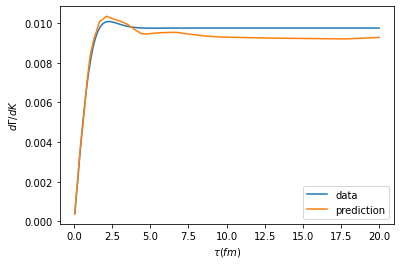

In [16]:
h_dim = 64
n_layers = 6
DATASET = 'method_0.csv'
model_file = f'n_layers_{n_layers}_hid_dim_{h_dim}_val_pc_err=3.62e-02.ckpt'
model_path = os.path.join("Results", "saved_models", model_file)
model = MLP.load_from_checkpoint(
    checkpoint_path=model_path,
    hidden_dim=h_dim,
    n_layers=n_layers
    )

P = 16
K = 3
T = 0.3

compare_with_data(P, K, T, DATASET, model, h_dim, n_layers)

In [9]:
Ps = np.logspace(np.log10(5), 3, 10).round(3)
Ts =  np.linspace(0.05, 1, 10).round(3)
Ks = np.linspace(0.1, 0.9, 9, endpoint=True)
ts = np.logspace(np.log10(5), 3, 10).round(3)

p_mean, p_norm = get_mean_norm(Ps)
T_mean, T_norm = get_mean_norm(Ts, log=False)
t_mean, t_norm = get_mean_norm(ts)
print(p_mean, p_norm)
print(T_mean, T_norm)
print(t_mean, t_norm)

1.8494850881985143 1.1505149978319906
0.525 0.475
1.8494850881985143 1.1505149978319906
